In [1]:
import pandas as pd
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
stopwords = set()
with open('hit_stopwords.txt', 'r', encoding='utf-8') as f:
    for line in f:
        word = line.strip()
        if word:
            stopwords.add(word)
stopwords.add(' ')

In [3]:
# 定义中文分词函数，并去除停用词
def chinese_tokenizer(text):
    words = [w for w in jieba.cut(text) if w not in stopwords]
    # print(words)
    return words

In [4]:
# 读入训练集数据
train_df = pd.read_csv('trainTwo.csv').fillna('')
# 将title列和tag列的数据合并到原始的文本数据中
train_text = train_df['content'] + ' ' + train_df['title'] + ' ' + train_df['subtitle']
train_text = train_text.apply(lambda x: ' '.join(chinese_tokenizer(x)))
# print(train_text)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\13414\AppData\Local\Temp\jieba.cache
Loading model cost 0.677 seconds.
Prefix dict has been built successfully.


0       8 日 郑州 飞 海南 航班 一位 老人 患有 脑梗 无法 握勺 进食 空姐 跪 老人 身边...
1                 朋友圈 消息 说 马航 机组 劫持 政府 谈判 未果 已 坠毁 ! 真的假 !
2       微信 公众 号 大鹰 刚刚 发布 中华 之鹰 00 中华 之鹰 00 男子 沙特 女同事 一...
3       2007 年 12 月 1 日 执行 中华人民共和国 卫生部 中猫 属于 界定 中 第一项 ...
4                       80 多岁 男神 辛苦 曝料 君 微博 视频 谢谢你们 北京 加油
                              ...                        
3995                             阿笨 占 每次 看到 俩 想 笑 真的 好 可爱
3996    2012 年 茅台 集团 中国青基会 合作 每年 出资 1 亿元 用于 开展 圆梦 行动 大...
3997    刚学 知识 大家 分享 一下 判断 牙膏 是否 健康 每个 牙膏 袋 尾部 都 色块 绿色 ...
3998    这是 纽约 布 錄 侖 49 街 10 大道 Maimonides 医院 金轮 新闻资讯 微...
3999    文章 悔过书 指 抄袭 高晓松 酒驾 悔过书 网友 发现 相似 度达 90% 出得 七位数 ...
Length: 4000, dtype: object


In [5]:
# 对中文文本进行向量化，并去除停用词
vectorizer = TfidfVectorizer()
train_features = vectorizer.fit_transform(train_text)

In [6]:
# 将标签转换为数字形式
train_labels = train_df['label']

In [7]:
# 训练朴素贝叶斯分类器
clf = MultinomialNB(alpha=1.0)
clf.fit(train_features, train_labels)

MultinomialNB()

In [8]:
# 使用训练好的模型进行预测
test_df = pd.read_csv('testTwo.csv').fillna('')

In [9]:
# 对测试集进行分词和去除停用词
test_df['content'] = test_df.apply(lambda row: ' '.join(chinese_tokenizer(row['content'])), axis=1)
# print(test_df['content'])
test_text = test_df['content']
test_features = vectorizer.transform(test_text)
test_pred = clf.predict(test_features)

In [10]:
# 将预测结果写入CSV文件
test_df['predicted_label'] = test_pred
test_df.to_csv('NBTestFourRes.csv', index=False)

In [11]:
# 计算准确率、精确率、召回率和F1值
accuracy = accuracy_score(test_df['label'], test_pred)
precision = precision_score(test_df['label'], test_pred, average='macro')
recall = recall_score(test_df['label'], test_pred, average='macro')
f1 = f1_score(test_df['label'], test_pred, average='macro')

In [12]:
# 输出结果
print("准确率：{:.4f}".format(accuracy))
print("精确率：{:.4f}".format(precision))
print("召回率：{:.4f}".format(recall))
print("F1值：{:.4f}".format(f1))

准确率：0.8310
精确率：0.8315
召回率：0.8307
F1值：0.8308


In [13]:
from sklearn.metrics import confusion_matrix

In [14]:
# 计算混淆矩阵
conf_mat = confusion_matrix(test_df['label'], test_pred)

In [15]:
# 可视化混淆矩阵
import seaborn as sns
import matplotlib.pyplot as plt

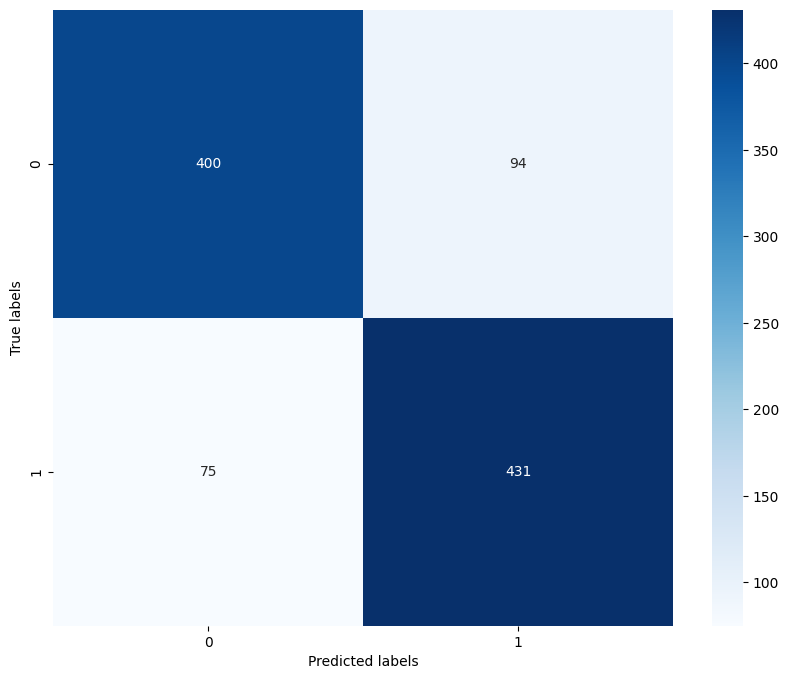

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [17]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

In [18]:
# 计算 ROC 曲线上的数据点
fpr, tpr, thresholds = roc_curve(test_df['label'], clf.predict_proba(test_features)[:, 1])

In [19]:
# 计算 PR 曲线上的数据点
precision, recall, thresholds = precision_recall_curve(test_df['label'], clf.predict_proba(test_features)[:, 1])

In [20]:
# 计算 ROC 曲线和 PR 曲线下的面积
roc_auc = auc(fpr, tpr)
pr_auc = auc(recall, precision)

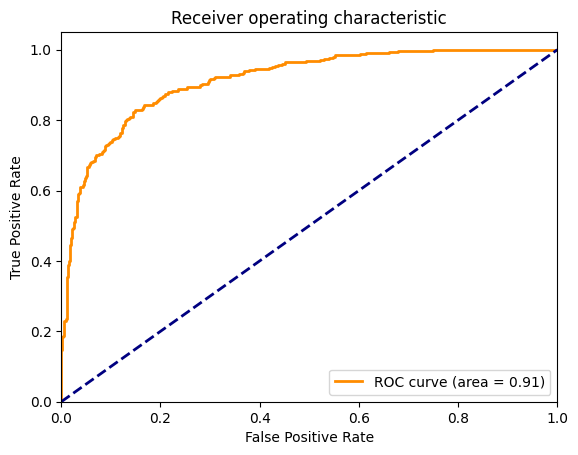

In [21]:
# 绘制 ROC 曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

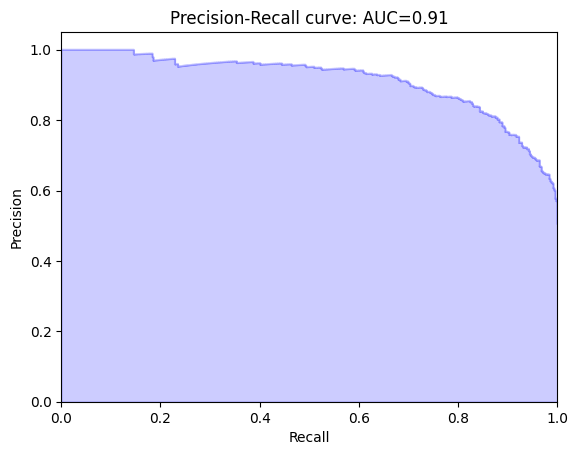

In [22]:
# 绘制 PR 曲线
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AUC={0:0.2f}'.format(pr_auc))
plt.show()